In [1]:
import uproot
import vector
import numpy as np
import awkward as ak
from scipy.stats import chi2
import matplotlib.pyplot as plt

In [2]:
num_events=100
pt_cut = 1.0 #GeV
eta_cut = 2.5
file="../pythia/WS_Showered_ttbar_semiLep_mu80_minJetpT25/data/dataset_showered_run_0.root"

In [3]:
def load_and_preprocess(file):
    with uproot.open(file+":fastjet") as f:
        #print(f.keys())
        trk_pt = f["trk_pT"].array()[0:num_events]
        trk_eta = f["trk_eta"].array()[0:num_events]
        trk_phi = f["trk_phi"].array()[0:num_events]
        trk_q = f["trk_q"].array()[0:num_events]
        trk_label = f["trk_label"].array()[0:num_events]
    trk_vect = vector.Array(ak.zip({"pt": trk_pt,"eta": trk_eta,"phi": trk_phi,"m": ak.zeros_like(trk_pt)}))
    mask = (trk_pt>pt_cut) & (np.abs(trk_eta)<eta_cut) & (trk_q!=0)
    trk_pass = trk_vect[mask]
    isHS=trk_label[mask]==-1
    return trk_pass, isHS

In [4]:
def do_PUPPI(trks, labels):
    trk_pair_1, trk_pair_2 = ak.unzip(ak.cartesian([trks,trks], axis=1, nested=True))
    distances = trk_pair_1.deltaR(trk_pair_2)+1e-8
    delta_R_mask = ((distances<0.3) & (distances>0.02))*1
    epsilon = (trk_pair_2.pt / distances)
    alpha_i = np.log(ak.sum(epsilon*delta_R_mask, axis=-1)+1e-20)
    sorted_alpha = ak.sort(alpha_i[~labels])
    num = ak.num(alpha_i[~labels])//2
    median_alpha = sorted_alpha[np.arange(len(num)), num]
    var_alpha = np.sqrt(ak.mean(alpha_i[~labels],axis=1)**2)
    chi_squared = (((alpha_i-median_alpha)>0)*1)*(alpha_i - median_alpha)**2/var_alpha**2
    PUPPI_weights = ak.unflatten(chi2.cdf(ak.flatten(chi_squared),1), ak.num(chi_squared))
    return PUPPI_weights, alpha_i

In [5]:
trks, labels = load_and_preprocess(file)
PUPPI_weights, alpha_i = do_PUPPI(trks,labels)
isHS=labels
isPU=~isHS

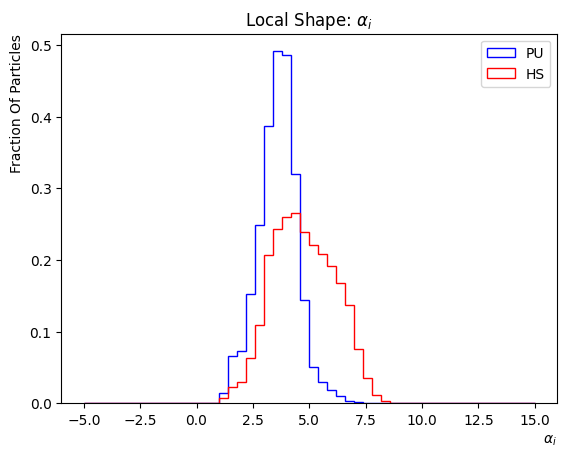

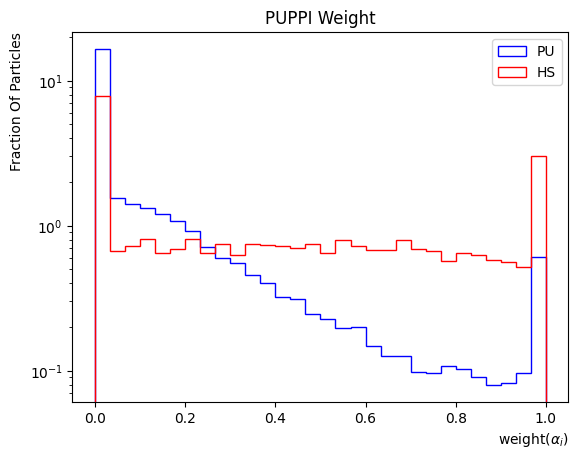

In [6]:
plt.title(r'Local Shape: $\alpha_i$')
plt.hist(ak.flatten(alpha_i[isPU]),bins=50,range=(-5,15),density=True,histtype='step',label='PU',color='b')
plt.hist(ak.flatten(alpha_i[isHS]),bins=50,range=(-5,15),density=True,histtype='step',label='HS',color='r')
plt.xlabel(r'$\alpha_i$',loc='right')
plt.ylabel("Fraction Of Particles",loc='top')
plt.legend()
plt.show()

plt.title("PUPPI Weight")
plt.hist(ak.flatten(PUPPI_weights[isPU]),bins=30,range=(0,1),density=True,histtype='step',label='PU',color='b')
plt.hist(ak.flatten(PUPPI_weights[isHS]),bins=30,range=(0,1),density=True,histtype='step',label='HS',color='r')
plt.xlabel(r'weight($\alpha_i$)',loc='right')
plt.ylabel("Fraction Of Particles",loc='top')
plt.yscale('log')
plt.legend()
plt.show()